# 2 - Evaluating deep learning models
In this notebook all the relevant deep learning models that were previously built will be evaluated.

## Setup

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import sys
import pathlib

# sets the path to the home directory of this repository so other modules can be imported. 
root_path = os.path.split(os.getcwd())[0]
assert root_path.endswith("mask-detection"), "The root path does not end with mask-detection: " + root_path 
sys.path.insert(0, root_path)
path = pathlib.Path(root_path + '/data/facemask-dataset')

# set the seed for reproducible results.
np.random.seed(0)
tf.random.set_seed(0)

# GPU settings
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

print(tf.__version__)

2.3.0


### Load datasets and models

In [2]:
from datasets.facemask_dataset import FacemaskDataset
batch_size = 64
train_percentage = 0.6
validation_percentage = 0.2
test_percentage = 0.2
ds = FacemaskDataset(path, batch_size, 200, 200, True, train_percentage, validation_percentage, test_percentage)

model = tf.keras.models.load_model(root_path + '/models/cnn1')

train: 36 validation: 12 test: 12


In [3]:
X = np.zeros((ds.test_size * batch_size, 200, 200, 3))
y_true = np.zeros((ds.test_size * batch_size, 1))
i = 0
for x, y in ds.actual_test_ds.unbatch().as_numpy_iterator():
    X[i] = x
    y_true[i] = y
    i += 1

In [5]:
metrics = model.evaluate(X, y_true, verbose=1, batch_size=batch_size, steps=ds.test_size)
print(f'Test loss: {metrics[0]:.4f}')
print(f'Test accuracy: {metrics[1]:.2f}')

12/12 [==============================] - 2s 134ms/step - loss: 0.2567 - acc: 0.9049
Test loss: 0.2567
Test accuracy: 0.90


In [6]:
y_pred = model.predict(X, verbose=1, batch_size=batch_size, steps=ds.test_size)
y_pred = y_pred > 0.5

12/12 [==============================] - 2s 133ms/step


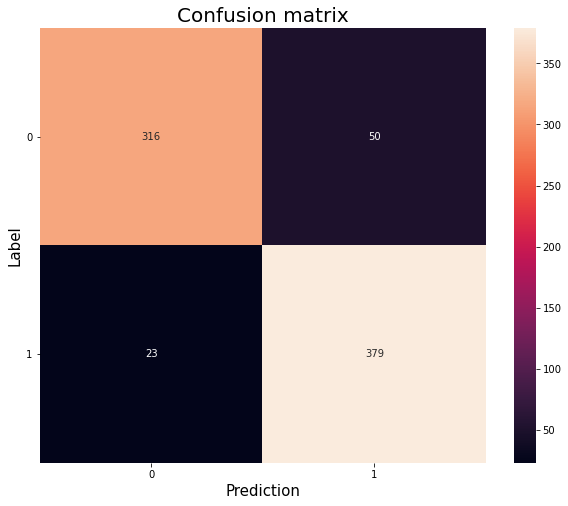

In [7]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

confusion_mtx = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,  annot=True, fmt='g')
plt.title("Confusion matrix", fontsize=20)
plt.xlabel('Prediction', fontsize=15)
plt.ylabel('Label', fontsize=15)
plt.yticks(rotation=0)
plt.show()

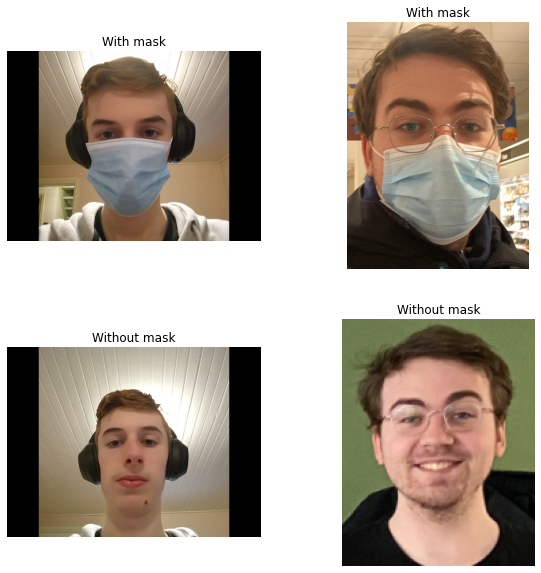

In [8]:
import PIL
path = pathlib.Path(root_path + '/data/self_images')
array = [{ "image_path": "/data/self_images/flyn_with_mask.jpg", "Mask": True, "Rotate": True},
        { "image_path": "/data/self_images/mario_with_mask.jpg", "Mask": True, "Rotate": False},
        { "image_path": "/data/self_images/flyn_without_mask.jpg", "Mask": False, "Rotate": True},
        { "image_path": "/data/self_images/mario_without_mask.jpg", "Mask": False, "Rotate": False}]

plt.figure(figsize=(10, 10))
i = 0
img_list = list()
for image_dict in array:
    image = PIL.Image.open(root_path + image_dict['image_path'])
    image = image.convert('RGB')
    if image_dict['Rotate']:
         image = image.rotate(90)
    img_list.append(image)
    masked = "Without mask"
    if image_dict['Mask']:
        masked = "With mask"
    ax = plt.subplot(2, 2, i + 1)
    plt.imshow(image)
    plt.title(masked)
    plt.axis("off")
    i+=1

prediction: True
prediction: True
prediction: False
prediction: False


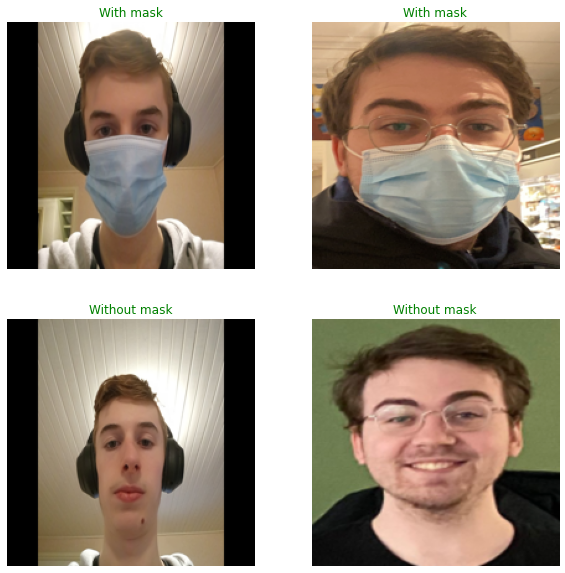

In [9]:
inputs = np.zeros((4, 200, 200, 3))

for i in range(len(img_list)):
    img = img_list[i]
    img = img.resize((200,200))
    img = np.asarray(img)
    inputs[i] = img
    
predictions = model.predict(inputs)
y_true = [True, True, False, False]

plt.figure(figsize=(10, 10))
i = 0
for x, y_pred, y in zip(img_list, predictions, y_true):
    color = 'r'
    masked = "Without mask"
    if (y_pred[0] > 0.5) == y:
        color = 'g'
    print('prediction:', y_pred[0]>0.5)
    if y:
        masked = "With mask"
    fontdict = { 'color': color }
    ax = plt.subplot(2, 2, i + 1)
    x = x.resize((200,200))
    plt.imshow(x)    
    plt.axis("off")
    plt.title(masked, fontdict = fontdict)
    i+=1